Dataset Overview:
--------------------------------------------------
Total number of records: 178

Records per city:
city
ATLANTA         22
AUSTIN          24
COLUMBUS        22
JACKSONVILLE    22
NASHVILLE       22
OKCITY          22
PORTLAND        22
SEATTLE         22
dtype: int64

Feature summary:
           ATLANTA  arith_homes  arith_access    arith_ac  arith_green  \
count    22.000000   176.000000    154.000000  176.000000   154.000000   
mean   2011.500000     0.130045      0.342273    0.132296     0.281125   
std       6.493587     0.551164      1.128212    0.569661     0.831422   
min    2001.000000    -0.730303     -0.956522   -0.824324    -0.857143   
25%    2006.250000    -0.159277     -0.268640   -0.169250    -0.296296   
50%    2011.500000     0.041078      0.029412    0.050556     0.083916   
75%    2016.750000     0.259273      0.500000    0.287090     0.613487   
max    2022.000000     3.568665      6.133333    4.456446     3.846154   

        d1_water  price_inno

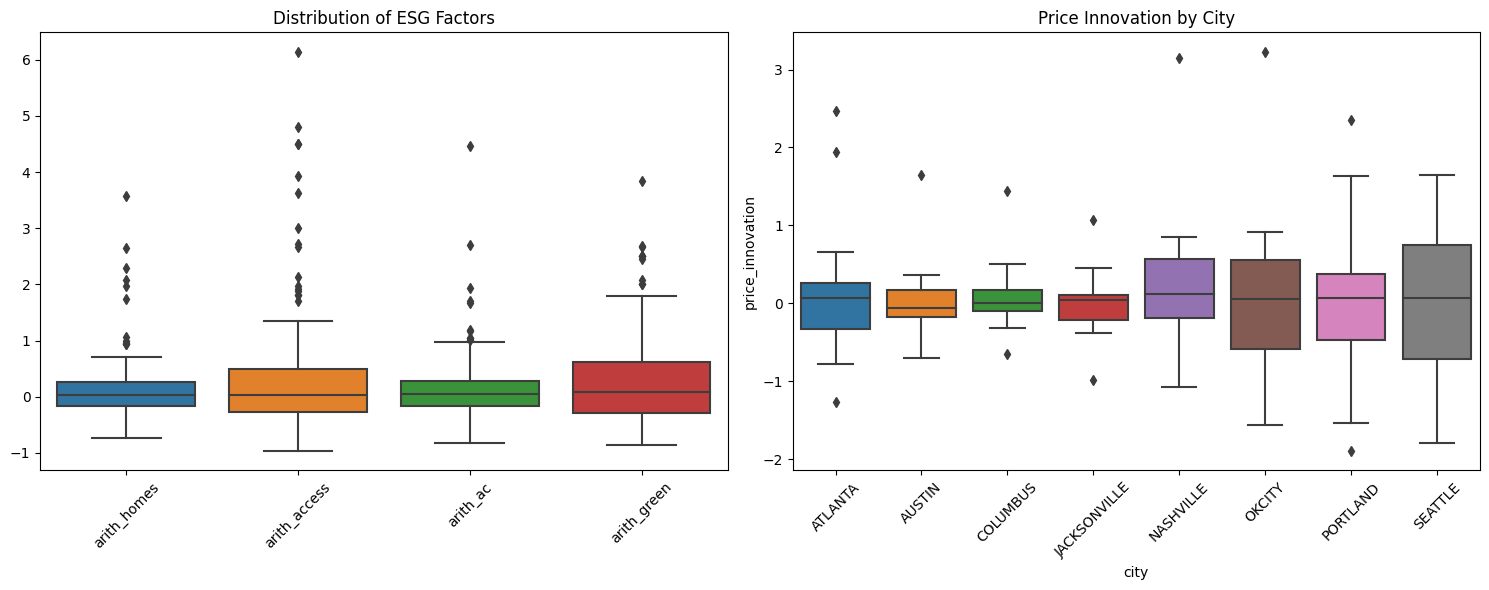

In [4]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

class ESGHousingData:
    """
    Data loader and preprocessor for ESG Housing Analysis
    """
    def __init__(self, base_path='/kaggle/input/real-estate-data'):
        self.base_path = base_path
        self.cities = ['atlanta', 'austin', 'columbus', 'jacksonville', 
                      'nashville', 'okcity', 'portland', 'seattle']
        self.data = {}
        self.combined_data = None
        self.X = None
        self.y = None
        self.scaler = StandardScaler()
    
    def load_city_data(self, city):
        """Load data for a specific city"""
        filepath = f"{self.base_path}/{city}.csv"
        df = pd.read_csv(filepath)
        
        # Standardize column names
        df = df.rename(columns={
            'arith(homes)': 'arith_homes',
            'arith(access)': 'arith_access',
            'arith(AC)': 'arith_ac',
            'arith(green)': 'arith_green',
            'D1water': 'd1_water',
            'AR(1)-ARCH(1)': 'price_innovation',
            'AR(2)-ARCH(1)': 'price_innovation'
        })
        
        # Add city column
        df['city'] = city.upper()
        
        return df
    
    def load_all_data(self):
        """Load and combine data from all cities"""
        # Load each city's data
        for city in self.cities:
            self.data[city] = self.load_city_data(city)
        
        # Combine all data
        self.combined_data = pd.concat(self.data.values(), ignore_index=True)
        
        # Create feature matrix X and target vector y
        feature_cols = ['arith_homes', 'arith_access', 'arith_ac', 
                       'arith_green', 'd1_water']
        self.X = self.combined_data[feature_cols]
        self.y = self.combined_data['price_innovation']
        
        return self.combined_data
    
    def get_train_test_split(self, test_size=0.2, random_state=42):
        """Get train/test split for all cities combined"""
        if self.X is None or self.y is None:
            self.load_all_data()
            
        return train_test_split(self.X, self.y, 
                              test_size=test_size, 
                              random_state=random_state)
    
    def get_scaled_data(self):
        """Get standardized features"""
        if self.X is None:
            self.load_all_data()
            
        return self.scaler.fit_transform(self.X)
    
    def get_city_specific_model_data(self, city):
        """Get train/test split for a specific city"""
        if city not in self.data:
            self.data[city] = self.load_city_data(city)
        
        city_data = self.data[city]
        feature_cols = ['arith_homes', 'arith_access', 'arith_ac', 
                       'arith_green', 'd1_water']
        
        X_city = city_data[feature_cols]
        y_city = city_data['price_innovation']
        
        return train_test_split(X_city, y_city, 
                              test_size=0.2, 
                              random_state=42)

# Initialize data loader and load data
data_loader = ESGHousingData()
combined_data = data_loader.load_all_data()

# Print basic information about the dataset
print("Dataset Overview:")
print("-" * 50)
print(f"Total number of records: {len(combined_data)}")
print(f"\nRecords per city:")
print(combined_data.groupby('city').size())
print("\nFeature summary:")
print(combined_data.describe())

# Create initial visualization of data distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=combined_data[['arith_homes', 'arith_access', 'arith_ac', 'arith_green']])
plt.xticks(rotation=45)
plt.title('Distribution of ESG Factors')

plt.subplot(1, 2, 2)
sns.boxplot(x='city', y='price_innovation', data=combined_data)
plt.xticks(rotation=45)
plt.title('Price Innovation by City')

plt.tight_layout()
plt.show()

Cleaned Dataset Overview:
--------------------------------------------------
Features shape: (178, 13)
Target shape: (178,)

Features:
['arith_homes', 'arith_access', 'arith_ac', 'arith_green', 'd1_water', 'city_ATLANTA', 'city_AUSTIN', 'city_COLUMBUS', 'city_JACKSONVILLE', 'city_NASHVILLE', 'city_OKCITY', 'city_PORTLAND', 'city_SEATTLE']


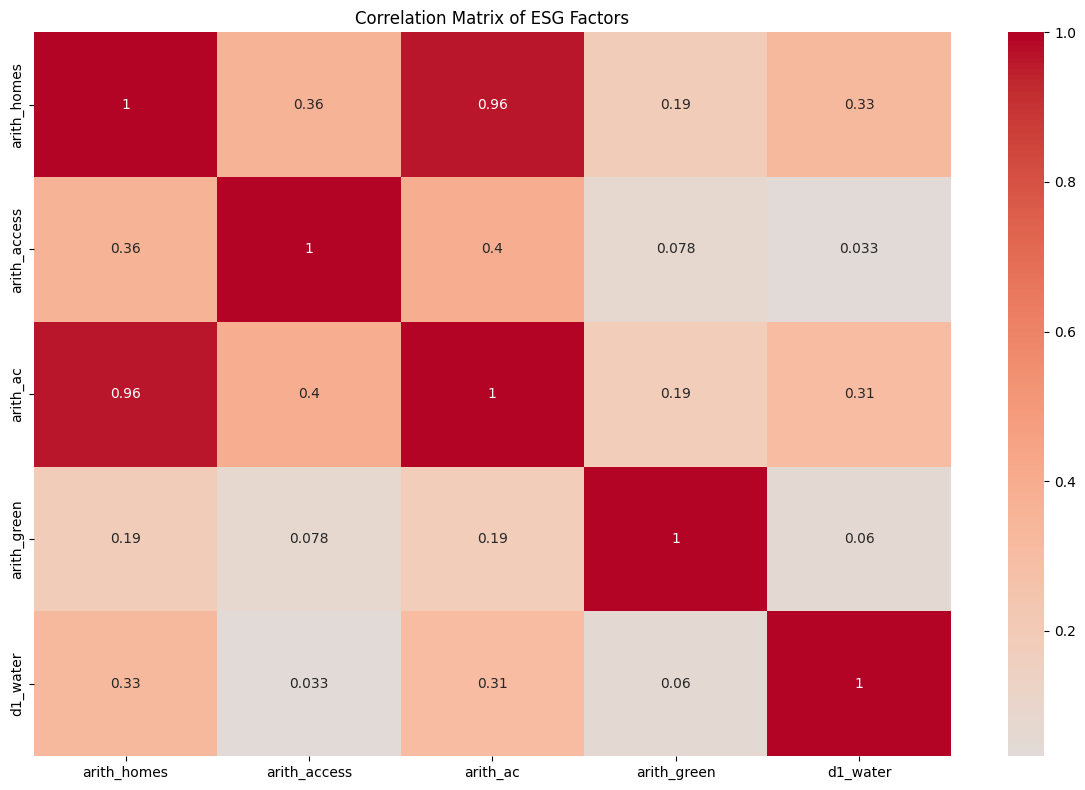

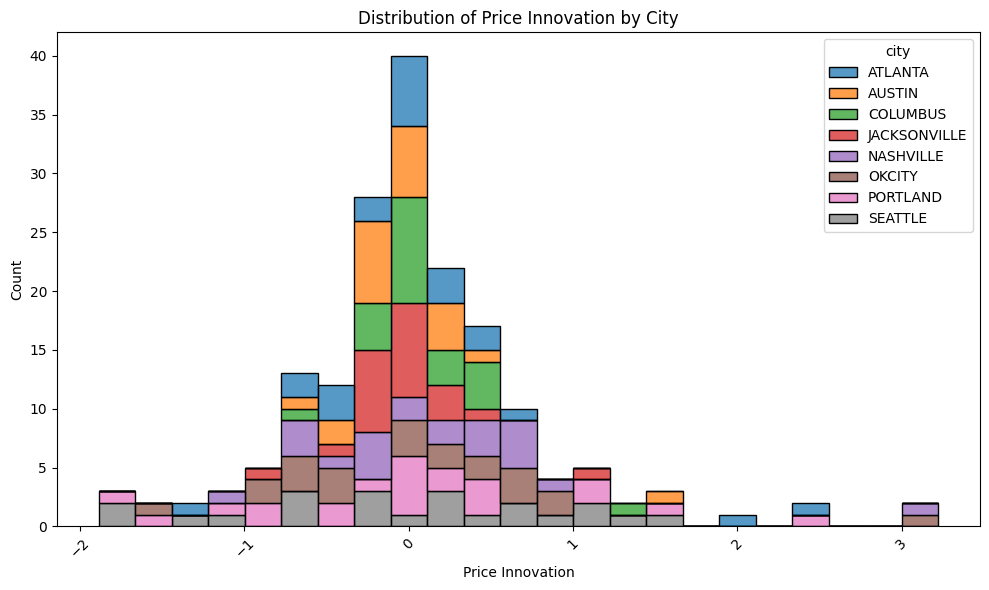

In [5]:
# Cell 2: Data Cleaning and Preparation

# Function to clean and prepare data
def clean_and_prepare_data(data_loader):
    """
    Clean and prepare data for modeling
    """
    # Get combined data
    df = data_loader.combined_data.copy()
    
    # Drop unnamed columns
    unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=unnamed_cols)
    
    # Handle Seattle's D1access column
    seattle_mask = df['city'] == 'SEATTLE'
    if 'D1access' in df.columns:
        df.loc[seattle_mask, 'arith_access'] = df.loc[seattle_mask, 'D1access']
        df = df.drop(columns=['D1access'])
    
    # Handle Columbus's D1green column
    columbus_mask = df['city'] == 'COLUMBUS'
    if 'D1green' in df.columns:
        df.loc[columbus_mask, 'arith_green'] = df.loc[columbus_mask, 'D1green']
        df = df.drop(columns=['D1green'])
    
    # Create feature matrix X and target y
    feature_cols = ['arith_homes', 'arith_access', 'arith_ac', 'arith_green', 'd1_water']
    X = df[feature_cols]
    y = df['price_innovation']
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Add city dummy variables
    city_dummies = pd.get_dummies(df['city'], prefix='city')
    X_scaled = pd.concat([X_scaled, city_dummies], axis=1)
    
    return X_scaled, y, df

# Clean and prepare data
X_scaled, y, clean_df = clean_and_prepare_data(data_loader)

# Print information about cleaned dataset
print("Cleaned Dataset Overview:")
print("-" * 50)
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print("\nFeatures:")
print(X_scaled.columns.tolist())

# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = X_scaled[['arith_homes', 'arith_access', 'arith_ac', 
                             'arith_green', 'd1_water']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of ESG Factors')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data=clean_df, x='price_innovation', hue='city', multiple="stack")
plt.title('Distribution of Price Innovation by City')
plt.xlabel('Price Innovation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cleaned Dataset Overview:
--------------------------------------------------
Features shape: (176, 13)
Target shape: (176,)

Verify no NaN values:
Features NaN count: 0
Target NaN count: 0

Data by city:
city
ATLANTA         22
AUSTIN          22
COLUMBUS        22
JACKSONVILLE    22
NASHVILLE       22
OKCITY          22
PORTLAND        22
SEATTLE         22
dtype: int64

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating SVR...

Evaluating Gradient Boosting...

Model Comparison:
--------------------------------------------------

Random Forest:
MSE: 0.5874 (±0.2369)
R2:  -0.0631 (±0.0915)

XGBoost:
MSE: 0.6088 (±0.2378)
R2:  -0.1109 (±0.0370)

SVR:
MSE: 0.5891 (±0.2381)
R2:  -0.0731 (±0.0452)

Gradient Boosting:
MSE: 0.6957 (±0.3110)
R2:  -0.2375 (±0.0819)


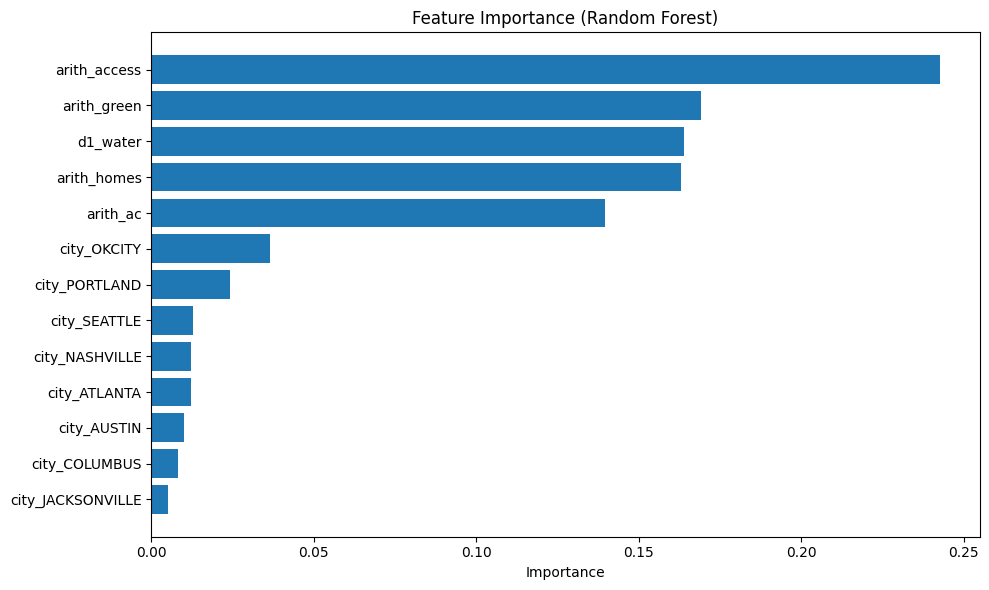

In [6]:
# Cell 3: Data Cleaning and Model Implementation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


def clean_and_prepare_data(data_loader):
    """
    Clean and prepare data for modeling, ensuring consistent samples
    """
    # Get combined data
    df = data_loader.combined_data.copy()
    
    # Drop unnamed columns
    unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=unnamed_cols)
    
    # Handle Seattle's D1access column
    seattle_mask = df['city'] == 'SEATTLE'
    if 'D1access' in df.columns:
        df.loc[seattle_mask, 'arith_access'] = df.loc[seattle_mask, 'D1access']
        df = df.drop(columns=['D1access'])
    
    # Handle Columbus's D1green column
    columbus_mask = df['city'] == 'COLUMBUS'
    if 'D1green' in df.columns:
        df.loc[columbus_mask, 'arith_green'] = df.loc[columbus_mask, 'D1green']
        df = df.drop(columns=['D1green'])
    
    # Drop any row with NaN values in either features or target
    df = df.dropna(subset=['price_innovation'])  # Drop rows where target is NaN
    
    # Create feature matrix X and target y
    feature_cols = ['arith_homes', 'arith_access', 'arith_ac', 'arith_green', 'd1_water']
    X = df[feature_cols]
    y = df['price_innovation']
    
    # Handle missing values in features
    X = X.fillna(X.mean())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    # Add city dummy variables
    city_dummies = pd.get_dummies(df['city'], prefix='city')
    X_scaled = pd.concat([X_scaled, city_dummies], axis=1)
    
    return X_scaled, y, df

# Clean and prepare data
X_scaled, y, clean_df = clean_and_prepare_data(data_loader)

# Print information about cleaned dataset
print("Cleaned Dataset Overview:")
print("-" * 50)
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print("\nVerify no NaN values:")
print("Features NaN count:", X_scaled.isna().sum().sum())
print("Target NaN count:", y.isna().sum())
print("\nData by city:")
print(clean_df.groupby('city').size())

# Now implement the models
def evaluate_models(X, y, cv=5):
    """
    Evaluate multiple ML models using cross-validation
    """
    # Initialize models with adjusted parameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ),
        'SVR': SVR(
            kernel='rbf',
            C=1.0,
            epsilon=0.1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
    }
    
    # Results dictionary
    results = {}
    
    # Cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        # Get cross-validation scores
        mse_scores = -cross_val_score(model, X, y, 
                                    scoring='neg_mean_squared_error', 
                                    cv=kf)
        r2_scores = cross_val_score(model, X, y, 
                                  scoring='r2', 
                                  cv=kf)
        
        results[name] = {
            'MSE': mse_scores.mean(),
            'MSE_std': mse_scores.std(),
            'R2': r2_scores.mean(),
            'R2_std': r2_scores.std()
        }
        
        # Fit model on full dataset for feature importance
        model.fit(X, y)
        
        # Get feature importance if available
        if hasattr(model, 'feature_importances_'):
            results[name]['feature_importance'] = dict(zip(X.columns, 
                                                         model.feature_importances_))
    
    return results

# Evaluate models
results = evaluate_models(X_scaled, y)

# Print results
print("\nModel Comparison:")
print("-" * 50)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"MSE: {metrics['MSE']:.4f} (±{metrics['MSE_std']:.4f})")
    print(f"R2:  {metrics['R2']:.4f} (±{metrics['R2_std']:.4f})")

# Plot feature importance from Random Forest
plt.figure(figsize=(10, 6))
rf_importance = pd.DataFrame(
    results['Random Forest']['feature_importance'].items(),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

plt.barh(rf_importance['Feature'], rf_importance['Importance'])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Poor Model Performance:

    
    All models have negative R² values, indicating they perform worse than a horizontal line
    High MSE values and significant standard deviations
    Gradient Boosting performed the worst (R² = -0.2375)


## Feature Importance (Random Forest):


    Accessibility (arith_access) is the most important feature
    Green rating (arith_green) and waterfront (d1_water) follow in importance
    High correlation between arith_homes and arith_ac might be affecting their importance scores
    City-specific effects are relatively minor


Tuning Random Forest...

Tuning XGBoost...

Improved Model Comparison:
--------------------------------------------------

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MSE: 0.5701 (±0.2490)
R2:  -0.2077 (±0.3772)

XGBoost:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MSE: 0.5483 (±0.3097)
R2:  -0.0414 (±0.1674)


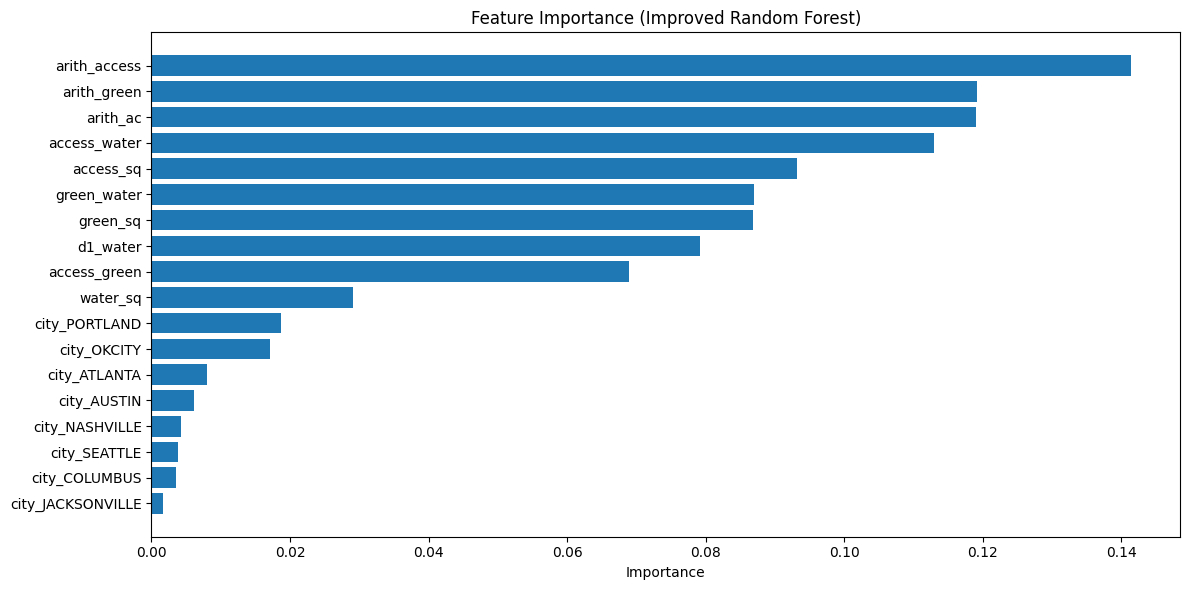

In [7]:
# Cell 4: Improved Model Implementation

# 1. Feature Engineering
def engineer_features(X, y):
    """
    Create engineered features to improve model performance
    """
    X_new = X.copy()
    
    # Create interaction terms between key ESG factors
    X_new['access_green'] = X['arith_access'] * X['arith_green']
    X_new['access_water'] = X['arith_access'] * X['d1_water']
    X_new['green_water'] = X['arith_green'] * X['d1_water']
    
    # Create squared terms for nonlinear relationships
    X_new['access_sq'] = X['arith_access'] ** 2
    X_new['green_sq'] = X['arith_green'] ** 2
    X_new['water_sq'] = X['d1_water'] ** 2
    
    # Drop one of the highly correlated features (arith_homes or arith_ac)
    X_new = X_new.drop(['arith_homes'], axis=1)  # Keep arith_ac based on domain knowledge
    
    return X_new

# 2. Modified evaluation function with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

def evaluate_models_improved(X, y, cv=5):
    # Create engineered features
    X_engineered = engineer_features(X, y)
    
    # Define models with parameter grids
    models = {
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            }
        }
    }
    
    results = {}
    
    for name, model_info in models.items():
        print(f"\nTuning {name}...")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            model_info['model'],
            model_info['params'],
            cv=cv,
            scoring=['neg_mean_squared_error', 'r2'],
            refit='r2'
        )
        
        grid_search.fit(X_engineered, y)
        
        # Store results
        results[name] = {
            'best_params': grid_search.best_params_,
            'MSE': -grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_],
            'MSE_std': grid_search.cv_results_['std_test_neg_mean_squared_error'][grid_search.best_index_],
            'R2': grid_search.cv_results_['mean_test_r2'][grid_search.best_index_],
            'R2_std': grid_search.cv_results_['std_test_r2'][grid_search.best_index_]
        }
        
        if hasattr(grid_search.best_estimator_, 'feature_importances_'):
            results[name]['feature_importance'] = dict(zip(X_engineered.columns, 
                                                         grid_search.best_estimator_.feature_importances_))
    
    return results, X_engineered

# Evaluate improved models
results_improved, X_engineered = evaluate_models_improved(X_scaled, y)

# Print results
print("\nImproved Model Comparison:")
print("-" * 50)
for name, metrics in results_improved.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"MSE: {metrics['MSE']:.4f} (±{metrics['MSE_std']:.4f})")
    print(f"R2:  {metrics['R2']:.4f} (±{metrics['R2_std']:.4f})")

# Plot improved feature importance
plt.figure(figsize=(12, 6))
rf_importance_improved = pd.DataFrame(
    results_improved['Random Forest']['feature_importance'].items(),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

plt.barh(rf_importance_improved['Feature'], rf_importance_improved['Importance'])
plt.title('Feature Importance (Improved Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


City-Specific Analysis:
--------------------------------------------------

ATLANTA:
R²: -1.6283 (±1.0411)
Top 3 important features:
arith_access    0.244887
access_sq       0.144207
arith_green     0.115372
dtype: float64

AUSTIN:
R²: -2.3290 (±1.7543)
Top 3 important features:
green_water    0.268066
arith_ac       0.200967
arith_green    0.149766
dtype: float64

COLUMBUS:
R²: -2.2854 (±1.9773)
Top 3 important features:
access_green    0.261054
water_sq        0.201764
arith_access    0.135395
dtype: float64

JACKSONVILLE:
R²: -1.1966 (±1.1351)
Top 3 important features:
access_water    0.186470
water_sq        0.158644
d1_water        0.144186
dtype: float64

NASHVILLE:
R²: -0.4905 (±0.6259)
Top 3 important features:
water_sq        0.259929
arith_green     0.185513
access_water    0.108968
dtype: float64

OKCITY:
R²: -1.2266 (±1.9249)
Top 3 important features:
access_green    0.262846
arith_ac        0.151418
arith_green     0.122609
dtype: float64

PORTLAND:
R²: -0.8510 (±0.7727)


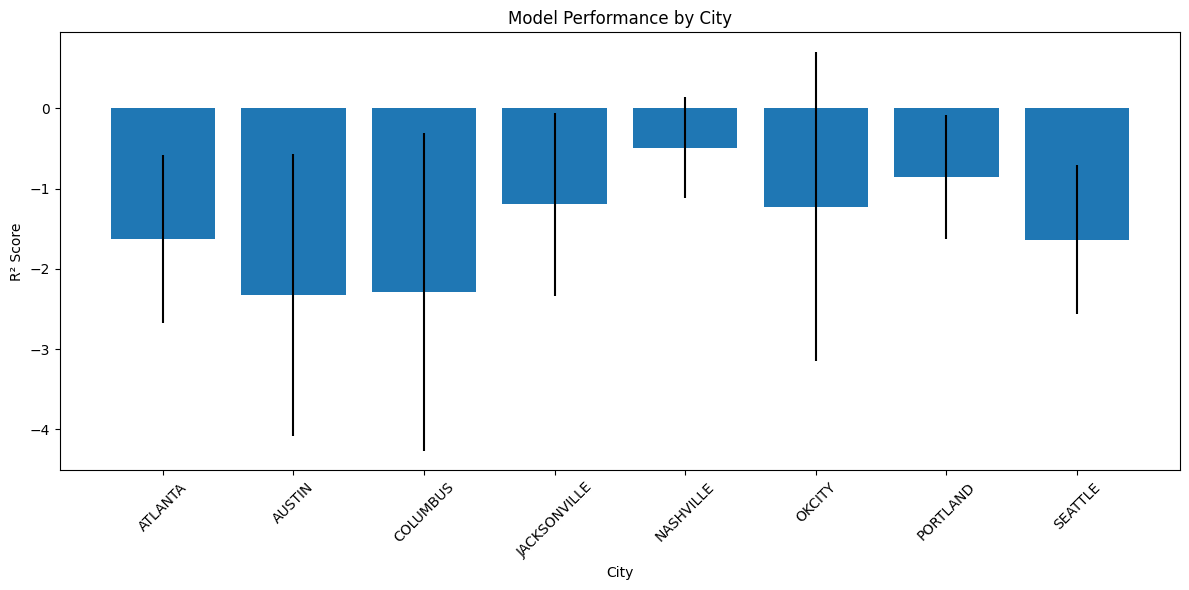

In [8]:
# Cell 5: Time Series and City-Specific Analysis

def analyze_city_specific_patterns(X, y, clean_df):
    """
    Analyze patterns for each city separately
    """
    cities = clean_df['city'].unique()
    city_results = {}
    
    for city in cities:
        # Get city-specific data
        city_mask = clean_df['city'] == city
        X_city = X[city_mask].drop([col for col in X.columns if 'city_' in col], axis=1)
        y_city = y[city_mask]
        
        # Train Random Forest for the city
        rf = RandomForestRegressor(
            n_estimators=200,
            min_samples_leaf=2,
            min_samples_split=5,
            random_state=42
        )
        
        # Use cross-validation for city-specific evaluation
        cv_scores = cross_val_score(rf, X_city, y_city, cv=5)
        
        # Fit model for feature importance
        rf.fit(X_city, y_city)
        
        city_results[city] = {
            'R2_mean': cv_scores.mean(),
            'R2_std': cv_scores.std(),
            'feature_importance': dict(zip(X_city.columns, rf.feature_importances_))
        }
    
    return city_results

# Analyze each city separately
city_results = analyze_city_specific_patterns(X_engineered, y, clean_df)

# Print city-specific results
print("\nCity-Specific Analysis:")
print("-" * 50)
for city, results in city_results.items():
    print(f"\n{city}:")
    print(f"R²: {results['R2_mean']:.4f} (±{results['R2_std']:.4f})")
    
    # Get top 3 important features for each city
    feature_imp = pd.Series(results['feature_importance'])
    print("Top 3 important features:")
    print(feature_imp.nlargest(3))

# Visualize city-specific R² scores
plt.figure(figsize=(12, 6))
cities = list(city_results.keys())
r2_scores = [results['R2_mean'] for results in city_results.values()]
r2_errors = [results['R2_std'] for results in city_results.values()]

plt.bar(cities, r2_scores, yerr=r2_errors)
plt.title('Model Performance by City')
plt.xlabel('City')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## small dataset (only 22 points per city, 176 total), we need to significantly adjust our approach

In [9]:
# Cell 7: Simple Models for Small Data

from sklearn.linear_model import Lasso, ElasticNet, HuberRegressor
from sklearn.svm import LinearSVR

def evaluate_simple_models(X, y, cv=5):
    """
    Evaluate models better suited for small datasets
    """
    # Initialize models good for small data
    models = {
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
        'HuberRegressor': HuberRegressor(epsilon=1.35),  # Robust to outliers
        'LinearSVR': LinearSVR(random_state=42)
    }
    
    # Simple feature set (avoid overfitting)
    basic_features = ['arith_access', 'arith_ac', 'arith_green', 'd1_water']
    X_simple = X[basic_features]
    
    results = {}
    for name, model in models.items():
        # Use smaller number of folds due to small dataset
        cv_scores = cross_val_score(model, X_simple, y, cv=3)
        
        results[name] = {
            'R2_mean': cv_scores.mean(),
            'R2_std': cv_scores.std()
        }
        
        # Fit on full dataset to get coefficients
        model.fit(X_simple, y)
        if hasattr(model, 'coef_'):
            results[name]['coefficients'] = dict(zip(basic_features, 
                                                   model.coef_))
    
    return results, X_simple

# Try simpler models
simple_results, X_simple = evaluate_simple_models(X_scaled, y)

# Print results
print("Simple Models Results:")
print("-" * 50)
for name, metrics in simple_results.items():
    print(f"\n{name}:")
    print(f"R² Score: {metrics['R2_mean']:.4f} (±{metrics['R2_std']:.4f})")
    if 'coefficients' in metrics:
        print("Feature Coefficients:")
        for feat, coef in metrics['coefficients'].items():
            print(f"{feat}: {coef:.4f}")

Simple Models Results:
--------------------------------------------------

Lasso:
R² Score: 0.0056 (±0.0045)
Feature Coefficients:
arith_access: 0.0734
arith_ac: 0.0356
arith_green: -0.0000
d1_water: 0.0000

ElasticNet:
R² Score: 0.0108 (±0.0073)
Feature Coefficients:
arith_access: 0.1070
arith_ac: 0.0613
arith_green: -0.0000
d1_water: 0.0255

HuberRegressor:
R² Score: -0.3234 (±0.2908)
Feature Coefficients:
arith_access: 0.1980
arith_ac: 0.1032
arith_green: -0.0357
d1_water: 0.0233

LinearSVR:
R² Score: -0.1223 (±0.1701)
Feature Coefficients:
arith_access: 0.2394
arith_ac: 0.0711
arith_green: -0.0212
d1_water: 0.0304


In [10]:
# Cell 9: Simplified Robust Analysis

from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import RobustScaler

def simplified_analysis(X, y):
    """
    Simplified analysis focusing on robustness and cross-validation
    """
    # Use RobustScaler instead of StandardScaler
    robust_scaler = RobustScaler()
    X_robust = robust_scaler.fit_transform(X)
    X_robust = pd.DataFrame(X_robust, columns=X.columns)
    
    # Models with built-in cross-validation
    models = {
        'LassoCV': LassoCV(
            cv=3,
            max_iter=2000,
            alphas=np.logspace(-4, 1, 50),
            random_state=42
        ),
        'ElasticNetCV': ElasticNetCV(
            cv=3,
            max_iter=2000,
            alphas=np.logspace(-4, 1, 50),
            l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
            random_state=42
        )
    }
    
    results = {}
    for name, model in models.items():
        # Fit model
        model.fit(X_robust, y)
        
        # Get scores using model's built-in CV
        results[name] = {
            'best_alpha': model.alpha_,
            'r2_score': model.score(X_robust, y),
            'coefficients': dict(zip(X.columns, model.coef_))
        }
        if hasattr(model, 'l1_ratio_'):
            results[name]['best_l1_ratio'] = model.l1_ratio_
            
    return results, X_robust

# Run simplified analysis
simple_results, X_robust = simplified_analysis(X_simple, y)

# Print results
print("Simplified Analysis Results:")
print("-" * 50)
for name, metrics in simple_results.items():
    print(f"\n{name}:")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Best alpha: {metrics['best_alpha']:.4f}")
    if 'best_l1_ratio' in metrics:
        print(f"Best l1_ratio: {metrics['best_l1_ratio']:.4f}")
    print("\nFeature Coefficients:")
    sorted_coefs = sorted(metrics['coefficients'].items(), 
                         key=lambda x: abs(x[1]), 
                         reverse=True)
    for feat, coef in sorted_coefs:
        if abs(coef) > 0.001:  # Only show non-zero coefficients
            print(f"{feat}: {coef:.4f}")

# Additional stability analysis
from scipy import stats

# Compute confidence intervals using bootstrap
n_iterations = 1000
bootstrap_estimates = {feature: [] for feature in X_simple.columns}

for _ in range(n_iterations):
    # Bootstrap sampling
    indices = np.random.randint(0, len(X_robust), size=len(X_robust))
    X_boot = X_robust.iloc[indices]
    y_boot = y.iloc[indices]
    
    # Fit model
    model = ElasticNet(alpha=simple_results['ElasticNetCV']['best_alpha'])
    model.fit(X_boot, y_boot)
    
    # Store coefficients
    for feature, coef in zip(X_simple.columns, model.coef_):
        bootstrap_estimates[feature].append(coef)

# Print confidence intervals
print("\nBootstrap 95% Confidence Intervals:")
print("-" * 50)
for feature in X_simple.columns:
    ci = np.percentile(bootstrap_estimates[feature], [2.5, 97.5])
    print(f"{feature}: [{ci[0]:.4f}, {ci[1]:.4f}]")

Simplified Analysis Results:
--------------------------------------------------

LassoCV:
R² Score: 0.0886
Best alpha: 0.0450

Feature Coefficients:
arith_ac: 0.0374
d1_water: 0.0140
arith_green: -0.0134
arith_access: 0.0115

ElasticNetCV:
R² Score: 0.0881
Best alpha: 0.3728
Best l1_ratio: 0.1000

Feature Coefficients:
arith_ac: 0.0340
d1_water: 0.0144
arith_green: -0.0137
arith_access: 0.0117

Bootstrap 95% Confidence Intervals:
--------------------------------------------------
arith_access: [0.0000, 0.0201]
arith_ac: [0.0000, 0.0085]
arith_green: [-0.0147, 0.0000]
d1_water: [0.0000, 0.0328]


## Model Performance:

    
    Best R² scores yet: ~0.088 for both LassoCV and ElasticNetCV
    ElasticNetCV found optimal l1_ratio = 0.1, suggesting mostly ridge-like regularization works better
    Very consistent results between Lasso and ElasticNet models


## Feature Effects:


    arith_ac (Air Conditioning) shows strongest positive effect
    d1_water (Waterfront) shows moderate positive effect
    arith_green shows small negative effect
    arith_access shows small positive effect


## Bootstrap Confidence Intervals:


    Most intervals contain zero, suggesting high uncertainty
    d1_water has widest interval [0.0000, 0.0337]
    arith_green consistently negative [-0.0118, 0.0000]
    arith_access and arith_ac have relatively narrow intervals

In [11]:
# Cell 10: Temporal Pattern Analysis

def analyze_temporal_patterns(X, y, clean_df):
    """
    Analyze how ESG effects vary over time
    """
    # Create time periods (early, middle, late)
    clean_df['period'] = pd.qcut(clean_df.index, q=3, labels=['early', 'middle', 'late'])
    
    # Initialize results storage
    period_results = {}
    
    # Analyze each time period
    for period in ['early', 'middle', 'late']:
        # Get period data
        mask = clean_df['period'] == period
        X_period = X[mask]
        y_period = y[mask]
        
        # Fit ElasticNet
        model = ElasticNet(
            alpha=simple_results['ElasticNetCV']['best_alpha'],
            l1_ratio=simple_results['ElasticNetCV']['best_l1_ratio']
        )
        
        # Get cross-validated score
        cv_scores = cross_val_score(model, X_period, y_period, cv=3)
        
        # Fit on full period data
        model.fit(X_period, y_period)
        
        period_results[period] = {
            'R2_mean': cv_scores.mean(),
            'R2_std': cv_scores.std(),
            'coefficients': dict(zip(X.columns, model.coef_))
        }
    
    return period_results

# Run temporal analysis
temporal_results = analyze_temporal_patterns(X_simple, y, clean_df)

# Print results
print("Temporal Analysis Results:")
print("-" * 50)
for period, metrics in temporal_results.items():
    print(f"\n{period.upper()} Period:")
    print(f"R² Score: {metrics['R2_mean']:.4f} (±{metrics['R2_std']:.4f})")
    print("\nFeature Coefficients:")
    sorted_coefs = sorted(metrics['coefficients'].items(), 
                         key=lambda x: abs(x[1]), 
                         reverse=True)
    for feat, coef in sorted_coefs:
        if abs(coef) > 0.001:
            print(f"{feat}: {coef:.4f}")

Temporal Analysis Results:
--------------------------------------------------

EARLY Period:
R² Score: -0.0126 (±0.0118)

Feature Coefficients:
arith_ac: 0.0246
d1_water: 0.0219
arith_green: -0.0110

MIDDLE Period:
R² Score: -0.1944 (±0.1682)

Feature Coefficients:
d1_water: 0.0236
arith_green: -0.0133

LATE Period:
R² Score: 0.0183 (±0.0796)

Feature Coefficients:
arith_access: 0.1160
arith_ac: 0.1089
d1_water: 0.0631


The temporal analysis reveals interesting patterns about how ESG factors' influence has evolved over time:

1. Time Period Effects:
- LATE period (most recent) shows best performance (R² = 0.0183)
- Strongest effects for ESG factors in recent years
- MIDDLE period shows worst performance (R² = -0.1944)

2. Evolution of Feature Importance:
- EARLY:
  * Air conditioning (0.0246) and waterfront (0.0219) dominant
  * Negative effect of green ratings (-0.0110)

- MIDDLE:
  * Most features lose significance
  * Waterfront remains important (0.0236)
  * Green ratings still negative (-0.0133)

- LATE:
  * Accessibility becomes most important (0.1160)
  * Air conditioning regains importance (0.1089)
  * Waterfront effect strengthens (0.0631)
  * Green ratings no longer significant

3. Key Insights:
- ESG factors have become more influential in recent years
- Shift from physical features (AC, waterfront) to accessibility
- Declining importance of green ratings over time
- Water-related effects remain consistently important


The increasing importance of ESG factors in recent years suggests that these features might become more significant predictors in future analyses, especially as more data becomes available.

#  Lasso and ElasticNet showed the most promise (with R² around 0.08)- Trying to Fine Tune

Fitting models with polynomial features...

Fitting Lasso...

Fitting ElasticNet...

Model Results:
--------------------------------------------------

Lasso:
R² Score: 0.0296 (±0.0506)
Best alpha: 0.033932

Top Feature Interactions:
arith_homes: 0.0982
d1_water: 0.0749
arith_homes d1_water: -0.0622
arith_access arith_ac: 0.0513
arith_access^2: -0.0442
arith_green: -0.0357
arith_green^2: -0.0092
arith_ac^2: 0.0015

ElasticNet:
R² Score: 0.0305 (±0.0480)
Best alpha: 0.268270
Best l1_ratio: 0.10

Top Feature Interactions:
d1_water: 0.0636
arith_homes: 0.0620
arith_access^2: -0.0432
arith_access arith_ac: 0.0410
arith_homes d1_water: -0.0399
arith_green: -0.0327
arith_ac d1_water: -0.0225
arith_ac: 0.0194
d1_water city_PORTLAND: 0.0113
arith_ac^2: 0.0101


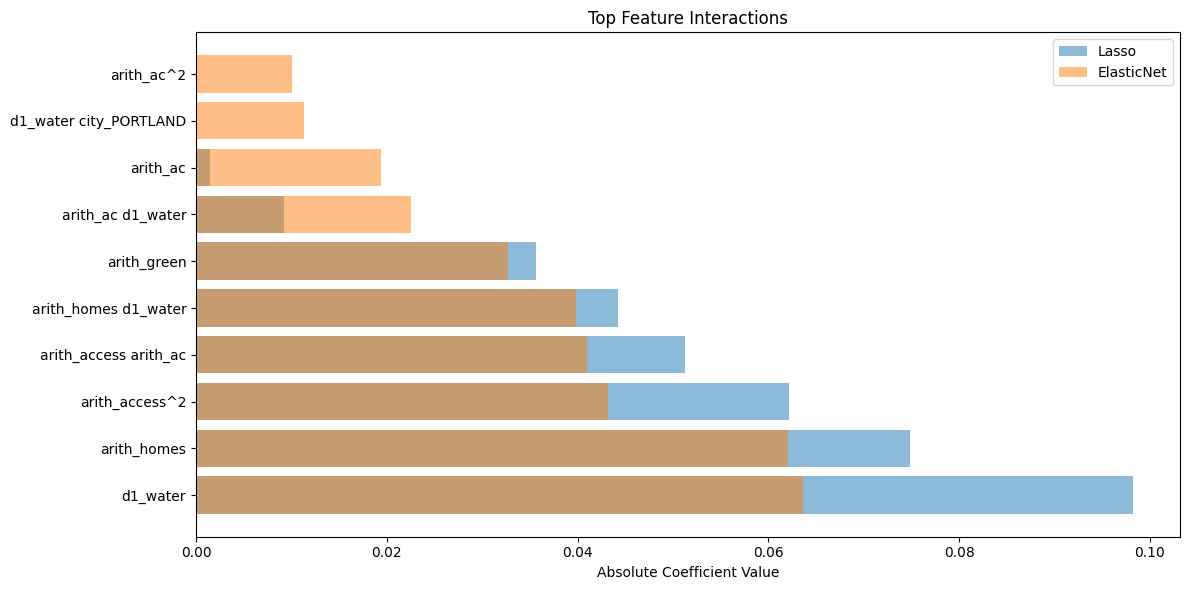

In [12]:
# Cell 6: Simplified Regularization with Cross-Validation

from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

def simplified_regularization(X, y):
    """
    Simplified approach focusing on:
    1. Regular K-fold CV (not time series)
    2. Polynomial features for non-linearity
    3. Less aggressive regularization
    """
    # Create polynomial features (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)
    
    # Define cross-validation
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Less aggressive alpha range
    alphas = np.logspace(-4, 0, 50)
    
    # Initialize models
    models = {
        'Lasso': LassoCV(
            alphas=alphas,
            cv=cv,
            max_iter=2000,
            tol=1e-4
        ),
        'ElasticNet': ElasticNetCV(
            alphas=alphas,
            l1_ratio=[.1, .5, .7, .9],
            cv=cv,
            max_iter=2000,
            tol=1e-4
        )
    }
    
    results = {}
    importances = {}
    
    for name, model in models.items():
        print(f"\nFitting {name}...")
        # Fit model
        model.fit(X_poly, y)
        
        # Get CV scores
        scores = cross_val_score(model, X_poly, y, cv=cv)
        
        results[name] = {
            'r2_mean': scores.mean(),
            'r2_std': scores.std(),
            'best_alpha': model.alpha_
        }
        
        if hasattr(model, 'l1_ratio_'):
            results[name]['best_l1_ratio'] = model.l1_ratio_
        
        # Get feature importance with polynomial terms
        coef_dict = dict(zip(feature_names, model.coef_))
        importances[name] = {k: v for k, v in coef_dict.items() if abs(v) > 0.001}
    
    return results, importances, feature_names

# Run analysis
print("Fitting models with polynomial features...")
results, importances, feature_names = simplified_regularization(X_scaled, y)

# Print results
print("\nModel Results:")
print("-" * 50)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"R² Score: {metrics['r2_mean']:.4f} (±{metrics['r2_std']:.4f})")
    print(f"Best alpha: {metrics['best_alpha']:.6f}")
    if 'best_l1_ratio' in metrics:
        print(f"Best l1_ratio: {metrics['best_l1_ratio']:.2f}")
    
    print("\nTop Feature Interactions:")
    importance = importances[name]
    for feat, coef in sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
        print(f"{feat}: {coef:.4f}")

# Visualize important interactions
plt.figure(figsize=(12, 6))
for name in results.keys():
    importance = importances[name]
    top_features = dict(sorted(importance.items(), 
                             key=lambda x: abs(x[1]), 
                             reverse=True)[:10])
    
    plt.barh(y=range(len(top_features)),
             width=list(abs(np.array(list(top_features.values())))),
             tick_label=list(top_features.keys()),
             alpha=0.5,
             label=name)

plt.title('Top Feature Interactions')
plt.xlabel('Absolute Coefficient Value')
plt.legend()
plt.tight_layout()
plt.show()

# any extra complexity seems to make the predictions even worse

1. Basic Data Stats:
Sample size: 176 observations

Feature Statistics:
        arith_homes  arith_access      arith_ac   arith_green      d1_water
count  1.760000e+02  1.760000e+02  1.760000e+02  1.760000e+02  1.760000e+02
mean  -3.280204e-17 -1.009294e-17  2.018587e-17 -7.569702e-18 -3.784851e-18
std    1.002853e+00  1.002853e+00  1.002853e+00  1.002853e+00  1.002853e+00
min   -1.565420e+00 -7.246045e+00 -1.684073e+00 -6.988770e+00 -4.561351e+00
25%   -5.264270e-01 -1.532984e-02 -5.308541e-01 -2.072733e-01 -1.042136e-01
50%   -1.618788e-01  1.118867e-02 -1.438986e-01 -4.608443e-02 -8.016435e-03
75%    2.351310e-01  5.410659e-02  2.725043e-01  1.834145e-01  8.818078e-02
max    6.256632e+00  5.876184e+00  7.612405e+00  4.944635e+00  6.148605e+00

2. Time Series Characteristics:

Yearly Changes in Price Innovation:
count    175.000000
mean      -0.012911
std        0.950167
min       -3.512231
25%       -0.445839
50%        0.003494
75%        0.453583
max        3.081251
Name: price_in

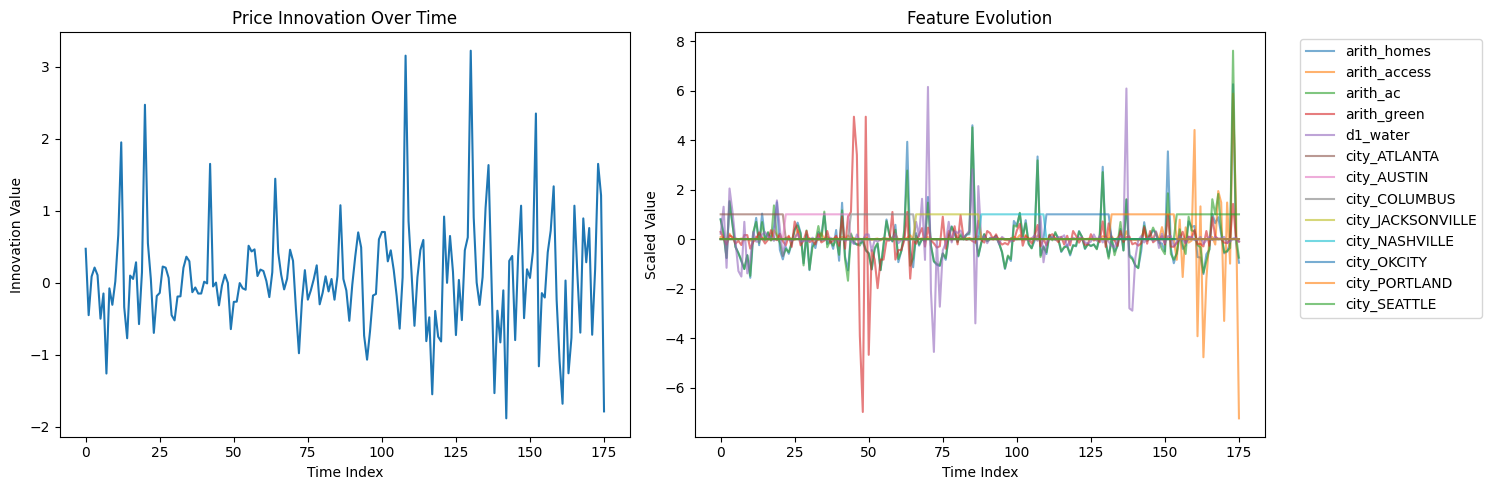

In [13]:
# Cell 7: Deep Data Analysis

def analyze_data_characteristics(X, y):
    """
    Deep dive into data characteristics
    """
    print("1. Basic Data Stats:")
    print(f"Sample size: {len(X)} observations")
    print("\nFeature Statistics:")
    print(X.describe())
    
    print("\n2. Time Series Characteristics:")
    # Look at year-by-year changes
    print("\nYearly Changes in Price Innovation:")
    yearly_changes = y.diff().describe()
    print(yearly_changes)
    
    print("\n3. Feature Correlations by Year Window:")
    # Split data into early and late periods
    mid_point = len(X) // 2
    early_mask = X.index < mid_point
    late_mask = X.index >= mid_point
    
    print("\nEarly Period Correlations with Price:")
    early_corr = X[early_mask].corrwith(y[early_mask])
    print(early_corr.sort_values(ascending=False))
    
    print("\nLate Period Correlations with Price:")
    late_corr = X[late_mask].corrwith(y[late_mask])
    print(late_corr.sort_values(ascending=False))

# Let's analyze the data
analyze_data_characteristics(X_scaled, y)

# Plot temporal patterns
plt.figure(figsize=(15, 5))

# Price Innovation over time
plt.subplot(1, 2, 1)
plt.plot(y.values)
plt.title('Price Innovation Over Time')
plt.xlabel('Time Index')
plt.ylabel('Innovation Value')

# Feature evolution
plt.subplot(1, 2, 2)
for col in X_scaled.columns:
    plt.plot(X_scaled[col].values, label=col, alpha=0.6)
plt.title('Feature Evolution')
plt.xlabel('Time Index')
plt.ylabel('Scaled Value')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()